In [1]:
## This notebook shows how to project your maps into a flat sky.

In [2]:
## Include the path to the package
import sys
import os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))

## Import modules and routines
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

## Other packages needed
import healpy as hp
import pylab as pl
import numpy as np

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

In [3]:
#################################################################
## START OF THE SIMULATION
## Flow is the following: 
##   sky -> instrument -> scanning strategy -> 
##   MAP2TOD -> (systematics) -> TOD2MAP
##################################################################

In [4]:
## Initialise our input maps 
## (for test purposes, we create the maps on-the-fly from a CAMB file)
## Note that HealpixFitsMap can take as input a fits file with sky maps already in.
sky_in = HealpixFitsMap('../s4cmb/data/test_data_set_lensedCls.dat', do_pol=True, 
                        fwhm_in=3.5, nside_in=512, map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

In [5]:
## Initialise our instrument
## Generate a focal plane with 4 Crate boards, each with 1 MUX board, 
## each with 1 Squid, each with 16 pairs of bolometers.
## The focal plane is 60 cm wide (square),
## and each detector beam is Gaussian with FWHM of 3.5 arcmin.
## We choose a pointing model with 5 parameters.
## Finally, we mount a continously rotating HWP @ 2Hz on the instrument.
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

In [6]:
## Initialize our scanning strategy
## Our scanning strategy will consist in scanning the Southern sky from Chile.
## We will perform 1 deep scan (CES) of roughly 4h.
## We will start the observation January, 1st 2013.
## We will set the sampling frequency of the detector to be 8 Hz, and we will 
## scan the sky at a speed of 0.4 deg/s.
scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../s4cmb/data/ut1utc.ephem', language='fortran')
scan.run()

In [7]:
## Let's now generate our TOD from our input sky, instrument, and scanning strategy
## Firts, we will use the difference of pairs of detectors to reconstruct 
## the polarisation (no demodulation).
## Once we will have the timestreams, we will reconstruct our maps on a 
## flat sky patch of width 20 deg with pixel size = 6.9 arcmin.

## MAP2TOD: scan the input sky to generate timestream channel-by-channel.
## this is currently the bottleneck in computation. Need to speed-up this routine!
## Hopefully everything is linear ;-)

## This is where you want to parallelize for big runs, so that different processors 
## (or groups or procs) focus on different scans. Here is the serial version:

## Loop over scans
for CESnumber in range(scan.nces):
    tod = TimeOrderedDataPairDiff(inst, scan, sky_in, CESnumber=CESnumber, projection='flat', 
                                  pixel_size=6.9, width=20.)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot = OutputSkyMap(nside=tod.nside_out, obspix=tod.obspix, npixsky=tod.npixsky)
        
    ## Scan input map to get TODs
    d = np.array([
            tod.map2tod(det) for det in tqdm(range(inst.focal_plane.nbolometer))])
        
    ## Project TOD to maps
    tod.tod2map(d, sky_out_tot)

100%|██████████| 128/128 [00:05<00:00, 20.63it/s]


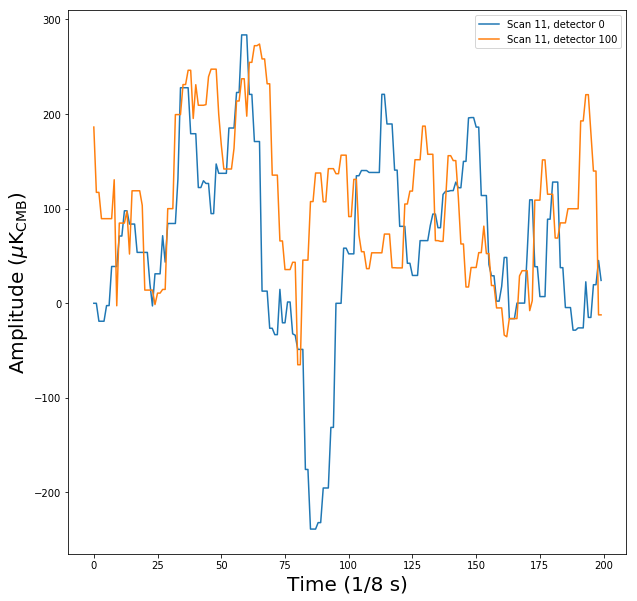

In [8]:
## Let's have a look at some TOD, that is 
## d(t) = I(t) + Q(t)cos(2*theta(t)) + U(t)sin(2*theta(t)).
## Keep in mind we set the sample rate at 8 Hz.
fig = pl.figure(figsize=(10, 10))
pl.plot(d[0][0:200], label='Scan 11, detector 0')
pl.plot(d[100][0:200], label='Scan 11, detector 100')
pl.legend()
pl.xlabel('Time (1/8 s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.show()

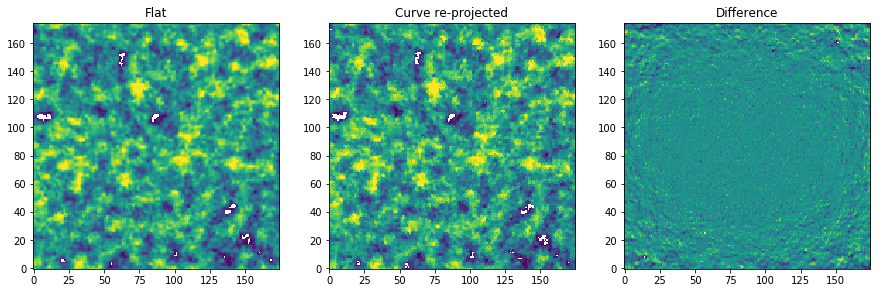

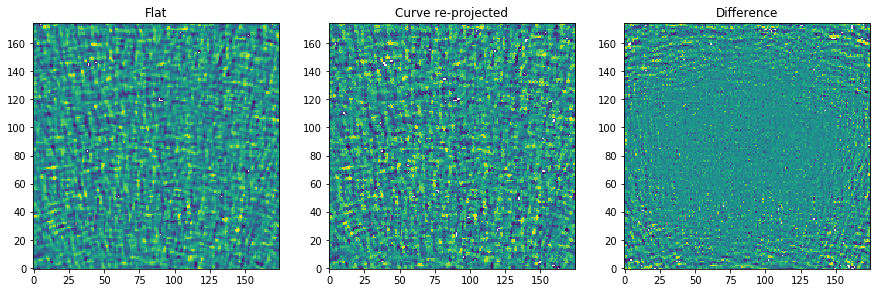

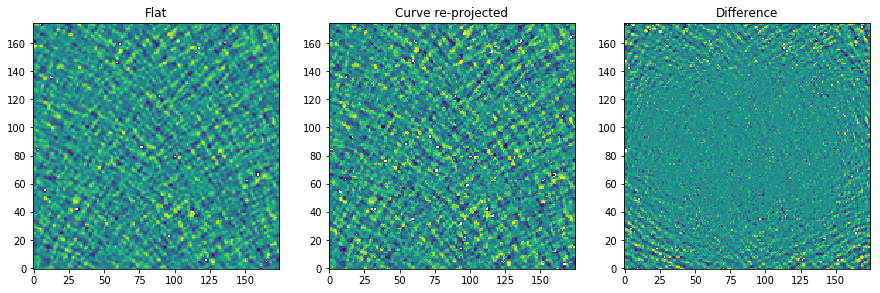

In [9]:
## Compare input and output by re-gridding the input (expected to be not really accurate, 
## we are just checking that we retrieve the same kind of maps).
## Notice that because we have performed internally a rotation of the input maps, 
## from (ra_mid, dec_mid) to (0, 0) to avoid projection artifact, the new
## center of the patch in the input map is (0, 0)!

flats = sky_out_tot.get_IQU()
maxmins = [250, 10, 10]
for flat_vec, curve_vec, maxmin in zip(flats, [tod.HealpixFitsMap.I, tod.HealpixFitsMap.Q, tod.HealpixFitsMap.U], maxmins):
    ## From 1d to 2d
    flat = np.zeros_like(flat_vec) * np.nan
    flat[flat_vec!=0]=flat_vec[flat_vec!=0]
    nx = int(np.sqrt(len(flat_vec)))
    flat = flat.reshape((nx, nx)).T

    ## Re-grid the input
    curve = hp.gnomview(curve_vec, rot=[0., 0.], xsize=nx, ysize=nx, reso=6.9, 
                notext=True, min=-250, max=250, title='', sub=122, return_projected_map=True, flip='geo')
    pl.clf()

    ## Plot things
    fig, ax = pl.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(flat, aspect='equal', origin='bottom',vmin=-maxmin, vmax=maxmin)
    ax[0].set_title('Flat')
    mask = flat != flat
    curve[mask] = None
    ax[1].imshow(curve, aspect='equal', origin='bottom',vmin=-maxmin, vmax=maxmin)
    ax[1].set_title('Curve re-projected')
    ax[2].imshow(curve - flat, aspect='equal', origin='bottom',vmin=-maxmin, vmax=maxmin)
    ax[2].set_title('Difference')
    pl.show()

In [10]:
## flat sky is bad. Sky is not flat.